# LaLonde Dataset

Economists have long-hypothesized about training program improving the labor market prospects of its participants.
Goverment policy makers were convinvced and goverment-funded job training programs were initiated.
One such large program was the National Supported Work (NSW) Demonstration, A part-federal part-privately program, implmented during 1975 to 1979 in 15 locations across the US.
The program provided 6-18 month training for individuals who had faced economic and social problems (such as women  receiving Aid to Families with Dependent Children, former drug addicts, ex-convicts, and former juvenile delinquents).

Participants were randomly assigned into experimental group (Support Work Programs) and control groups.
However, due to the long duration of the study, participants joining the program at the beginning had different charachteristics than people joining later.  
Therefore, his covariate shift should be adjusted for in order to estimate the true causal effect of the job-program on future employment.


This dataset had become a common benchamrk for causal analysis over the years.  
Original analysis of the study was done by [Robert LaLonde](https://en.wikipedia.org/wiki/Robert_LaLonde) and published in his 1986 [Evaluating the Econometric Evaluations of Training Programs with Experimental Data](http://people.hbs.edu/nashraf/LaLonde_1986.pdf) paper.  
However, we will follow a later propensity-based analysis made by Dehejia and Wahba in their 1999 [Causal Effects in Non-Experimental Studies: Reevaluating the Evaluation of Training Programs](https://users.nber.org/~rdehejia/papers/dehejia_wahba_jasa.pdf).

## The Data
First, let's download the dataset from [Rajeev Dehejia's webpage](https://users.nber.org/~rdehejia/nswdata2.html).

In [1]:
import pandas as pd

columns = ["training",   # Treatment assignment indicator
           "age",        # Age of participant
           "education",  # Years of education
           "black",      # Indicate whether individual is black
           "hispanic",   # Indicate whether individual is hispanic
           "married",    # Indicate whether individual is married
           "no_degree",  # Indicate if individual has no high-school diploma
           "re74",       # Real earnings in 1974, prior to study participation
           "re75",       # Real earnings in 1975, prior to study participation
           "re78"]       # Real earnings in 1978, after study end

treated = pd.read_csv("http://www.nber.org/~rdehejia/data/nswre74_treated.txt", 
                      delim_whitespace=True, header=None, names=columns)
control = pd.read_csv("http://www.nber.org/~rdehejia/data/nswre74_control.txt",
                      delim_whitespace=True, header=None, names=columns)
lalonde = pd.concat([treated, control], ignore_index=True)
lalonde = lalonde.sample(frac=1.0, random_state=42)  # Shuffle

print(lalonde.shape)
lalonde.head()

(445, 10)


training   age  education  black  hispanic  married  no_degree  \
284       0.0  28.0       12.0    1.0       0.0      1.0        0.0   
358       0.0  19.0       11.0    1.0       0.0      0.0        1.0   
117       1.0  20.0       12.0    1.0       0.0      0.0        0.0   
412       0.0  25.0       11.0    1.0       0.0      0.0        1.0   
70        1.0  27.0        9.0    1.0       0.0      0.0        1.0   

          re74       re75       re78  
284      0.000     0.0000     0.0000  
358   1626.623     0.0000     0.0000  
117      0.000   377.5686  1652.6370  
412  15209.990  3072.7260   284.6584  
70       0.000     0.0000     0.0000

We can see the dataset has 445 inidividuals in it, as described on Dehejia's page.  

### Design matrix
#### Earning indications
Following the analysis performed by Gelman et al. on their [arm](https://cran.r-project.org/web/packages/arm/index.html) R library, we will create two indicator variables indicating no earnings in 1974 and 1975.

In [2]:
lalonde = lalonde.join((lalonde[["re74", "re75"]] == 0).astype(int), rsuffix=("=0"))
lalonde.head()

training   age  education  black  hispanic  married  no_degree  \
284       0.0  28.0       12.0    1.0       0.0      1.0        0.0   
358       0.0  19.0       11.0    1.0       0.0      0.0        1.0   
117       1.0  20.0       12.0    1.0       0.0      0.0        0.0   
412       0.0  25.0       11.0    1.0       0.0      0.0        1.0   
70        1.0  27.0        9.0    1.0       0.0      0.0        1.0   

          re74       re75       re78  re74=0  re75=0  
284      0.000     0.0000     0.0000       1       1  
358   1626.623     0.0000     0.0000       0       1  
117      0.000   377.5686  1652.6370       1       0  
412  15209.990  3072.7260   284.6584       0       0  
70       0.000     0.0000     0.0000       1       1

#### Factorizing education
Since years of schooling are not to be taken by their numerical values, we will factorize it into indicator variables.

In [3]:
lalonde = pd.get_dummies(lalonde, columns=["education"], drop_first=True)
print(lalonde.shape)
lalonde.head()

(445, 24)


training   age  black  hispanic  married  no_degree       re74  \
284       0.0  28.0    1.0       0.0      1.0        0.0      0.000   
358       0.0  19.0    1.0       0.0      0.0        1.0   1626.623   
117       1.0  20.0    1.0       0.0      0.0        0.0      0.000   
412       0.0  25.0    1.0       0.0      0.0        1.0  15209.990   
70        1.0  27.0    1.0       0.0      0.0        1.0      0.000   

          re75       re78  re74=0  ...  education_7.0  education_8.0  \
284     0.0000     0.0000       1  ...              0              0   
358     0.0000     0.0000       0  ...              0              0   
117   377.5686  1652.6370       1  ...              0              0   
412  3072.7260   284.6584       0  ...              0              0   
70      0.0000     0.0000       1  ...              0              0   

     education_9.0  education_10.0  education_11.0  education_12.0  \
284              0               0               0               1   
358              0               0               1               0   
117              0               0               0               1   
412              0               0               1               0   
70               1               0               0               0   

     education_13.0  education_14.0  education_15.0  education_16.0  
284               0               0               0               0  
358               0               0               0               0  
117               0               0               0               0  
412               0               0               0               0  
70                0               0               0               0  

[5 rows x 24 columns]

### Variables selection
Lastly, we extract the covariates, treatment and outcome variables

In [4]:
a = lalonde.pop("training")
y = lalonde.pop("re78")
X = lalonde
X.shape, a.shape, y.shape

((445, 22), (445,), (445,))

## The Model
After defining the design matrix `X`, we can continue to define the causal model.

In the spirit of Dehejia and Wahba's propensity-based analysis, 
we will use an Inverse Treatment Probability Weighting (IPTW, or IPW) causal model.  
Briefly, this model will model the probability of participants to be assigned to job-training program and use it to emulate two equal-sized populations: one of those being assigned to the program and another of ones who don't.
In this synthetic population, we could use the actual earnings in 1978 to estimate what would have happen if everyone were to join the program or everyone were to not be part of it at all.

Before we define the causal model itself, we will need to use a machine learning model to estimate the propensity score $\Pr[A=1|X]$ - the probability of each participant to be assigned to job training.  
Following the design matrix we prepared above, and given the binary nature of our treatment, we will choose a logistic regression for this task.

In [5]:
from sklearn.linear_model import LogisticRegression

learner = LogisticRegression(penalty='none',  # No regularization, new in scikit-learn 0.21.*
                             solver='lbfgs',
                             max_iter=500)    # Increaed to achieve convergence with 'lbfgs' solver

Once we defined a learner, we can simply plug it into the causal model

In [6]:
from causallib.estimation import IPW

ipw = IPW(learner)

## Estimating Causal Effect
Once we defined the causal model (yes, that all it took), we can move on to estimate the effect of job-training on yearly earnings.

First, we will fit our causal model.  
Second, we'll predict the potential outcomes: what would be the earnings in 1978 if everyone were to join the job-training or everyone were to not join the training program.
Third, we will use the two potential outcomes to estimate the effect: the difference of the two potential outcomes.

In [7]:
ipw.fit(X, a)
outcomes = ipw.estimate_population_outcome(X, a, y)
effect = ipw.estimate_effect(outcomes[1], outcomes[0])

Checking the potential outcomes, we can see that the average earnings at the end of the study (1978) if everyone would have join the program (`1`) is 6141\$ while the averge earnings if everyone would have not join the program (`0`) is 4598\$.

In [8]:
outcomes

0.0    4598.414070
1.0    6141.051856
dtype: float64

Therefore we can conclude that the average additive effect (`diff`) of job training on income is 1543\$.

In [9]:
effect

diff    1542.637786
dtype: float64

Indeed, we can conclude that job-training accounts for an income gain of 1543\$ on average.

### Unadjusted estimation
To compare, we can ask what conclusion would have we achive if we did not control for confounding.  
What would've been the result if we haven't adjusted for treatment assignment biases and treated the data as if it came from a randomized control trial?

In [10]:
from causallib.estimation import MarginalOutcomeEstimator

moe = MarginalOutcomeEstimator(None).fit(X, a, y)
outcomes = moe.estimate_population_outcome(X, a, y)
moe.estimate_effect(outcomes[1], outcomes[0])

diff    1794.342404
dtype: float64

We can see that when failing to adjust for confounding factors, we overestimate the effect of job training on income by 252\$.  
This seemingly negligible bias accounts for \~16\% of our estimation, and probably due to the study being randomized in nature.

To see why the differences between estimation methods, we can examine the how balanced were the treatment groups before and after IP weighting.  
We can check that using a _Love plot_, a graphical way to present distribution distance between the treated and untreated. It plots the standardized-mean-difference between the treatment groups for each covariate marginally.

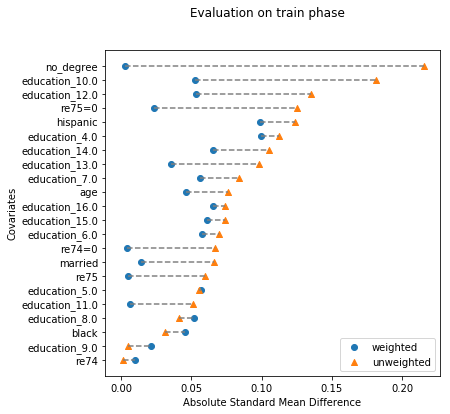

In [11]:
%matplotlib inline
from causallib.evaluation import PropensityEvaluator

evaluator = PropensityEvaluator(ipw)
evaluation_results = evaluator.evaluate_simple(X, a, y, plots=["covariate_balance_love"])

fig = evaluation_results.plots["covariate_balance_love"].get_figure()
fig.set_size_inches(6, 6)  # set a more compact size than default
fig;

We can see that prior to applying IP-weighting (orange triangles), the maximal absolute mean-difference across treatment groups was around ~0.2 standard-deviations. 
This can easily bias a simple marginal comparison (i.e., simply check the outcome of treated against the outcome of untreated), since we see the groups are not marginally similar.  
For example, one could argue that difference in outcome is contributed to the fact that the two treatment groups differ on their percentage of people owning a high-school diploma (`no_degree`).  
Since the treatment groups have different distribution of characteristics, it should be accounted for in a causal inference analysis, for-example: the importance-sampling-like scheme applied by the IPW model. 
After balancing (blue dots), we see that the marginal difference between the groups' covariate distribution is much smaller on average, suggesting that the IPW model had successfully balanced the dataset.